In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA, FastICA
from sklearn.linear_model import SGDRegressor
import warnings
warnings.filterwarnings('ignore')
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor  
from sklearn.svm import SVR
from prettytable import PrettyTable
from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [2]:
train_df=pd.read_csv("train.csv")
test_df=pd.read_csv("test.csv")
sample=pd.read_csv("sample_submission_V9Inaty.csv")

In [6]:
train_df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [89]:
train_df.shape

(550068, 12)

## EDA

### Plotting Train Data

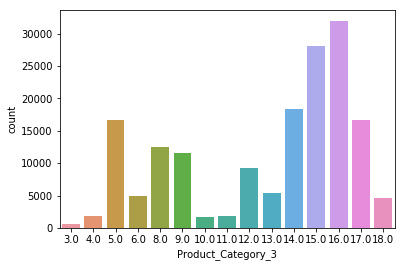

In [94]:
sns.countplot(x='Product_Category_3', data=train_df)

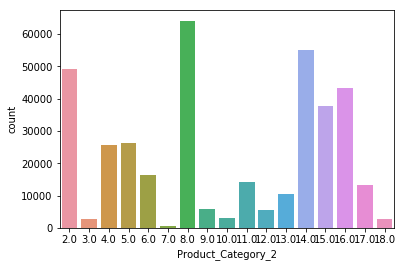

In [48]:
sns.countplot(x='Product_Category_2', data=train_df)

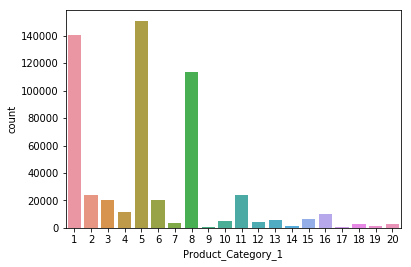

In [47]:
sns.countplot(x='Product_Category_1', data=train_df)

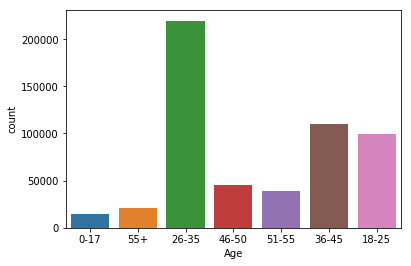

In [19]:
sns.countplot(x='Age', data=train_df)

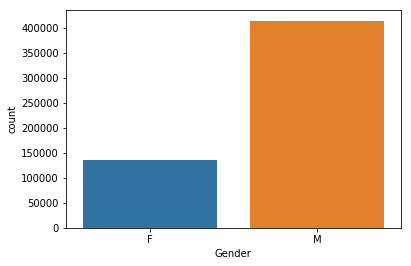

In [20]:
sns.countplot(x='Gender', data=train_df)

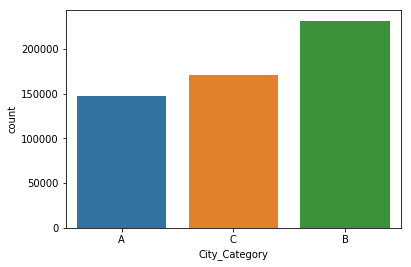

In [22]:
sns.countplot(x='City_Category', data=train_df)

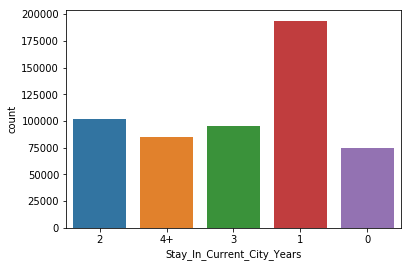

In [23]:
sns.countplot(x='Stay_In_Current_City_Years', data=train_df)

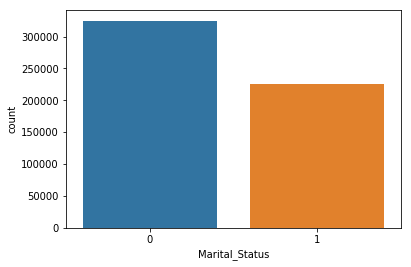

In [25]:
sns.countplot(x='Marital_Status', data=train_df)

### Plotting Test Data

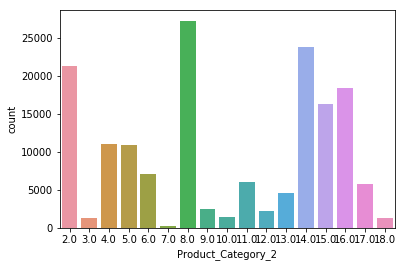

In [49]:
sns.countplot(x='Product_Category_2', data=test_df)

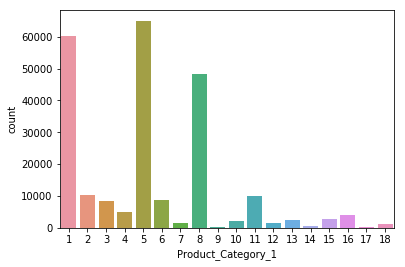

In [50]:
sns.countplot(x='Product_Category_1', data=test_df)

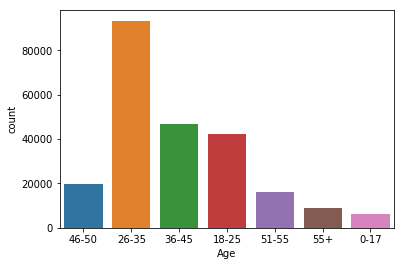

In [51]:
sns.countplot(x='Age', data=test_df)

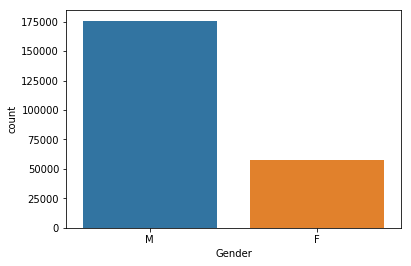

In [52]:
sns.countplot(x='Gender', data=test_df)

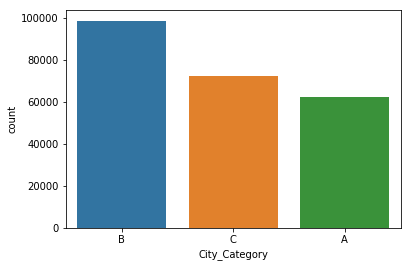

In [53]:
sns.countplot(x='City_Category', data=test_df)

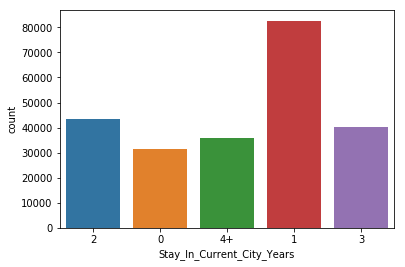

In [54]:
sns.countplot(x='Stay_In_Current_City_Years', data=test_df)

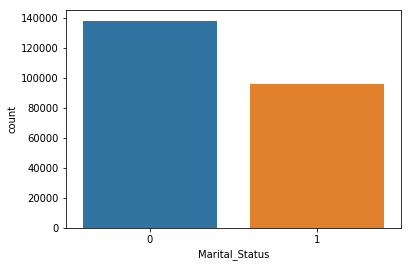

In [55]:
sns.countplot(x='Marital_Status', data=test_df)

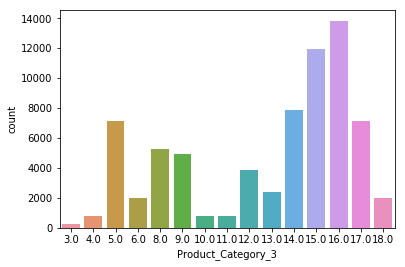

In [95]:
sns.countplot(x='Product_Category_3', data=test_df)

### Plotting Purchase(y) Data

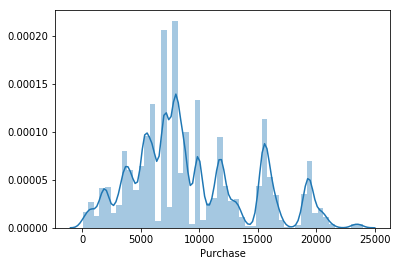

In [32]:
sns.distplot(x)

In [182]:
train_df.duplicated(subset=['User_ID','Product_ID']).any()

False

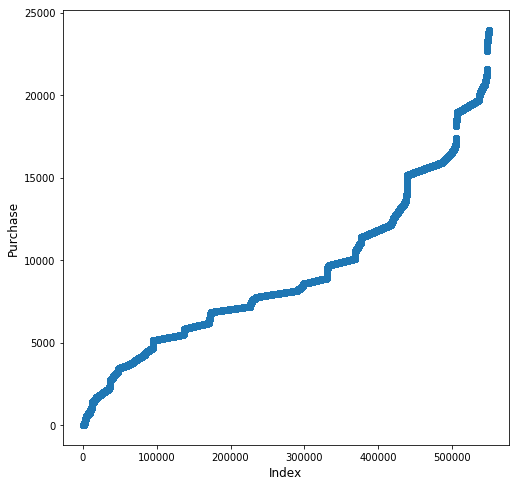

In [46]:
plt.figure(figsize=(8,8))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.Purchase.values))
plt.xlabel('Index', fontsize=12)
plt.ylabel('Purchase', fontsize=12)
plt.show()

In [3]:
train_df=train_df[train_df.Purchase < np.percentile(train_df.Purchase,99)]

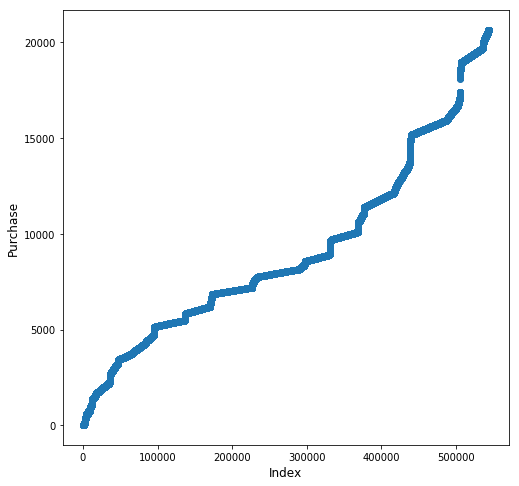

In [85]:
plt.figure(figsize=(8,8))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.Purchase.values))
plt.xlabel('Index', fontsize=12)
plt.ylabel('Purchase', fontsize=12)
plt.show()

In [4]:
train_df = train_df[train_df.Product_Category_1 != 19]
train_df = train_df[train_df.Product_Category_1 != 20]

In [5]:
train_df.shape

(540412, 12)

We removed values with Product_Category_1 values of 19 and 20 from train data as this data did not exist in test data.

We also stored only the data in the 99th percentile to improve model perforamcen by removing outliers.

We added 2 new features which give us an average purchase value based on user and product.

### Encoding and featurization

In [6]:
train_df['Age'].loc[(train_df['Age'] == "0-17")] = 9
train_df['Age'].loc[(train_df['Age'] == "55+")] = 60
train_df['Age'].loc[(train_df['Age'] == "26-35")] = 30
train_df['Age'].loc[(train_df['Age'] == "46-50")] = 48
train_df['Age'].loc[(train_df['Age'] == "51-55")] = 53
train_df['Age'].loc[(train_df['Age'] == "36-45")] = 40
train_df['Age'].loc[(train_df['Age'] == "18-25")] = 22

In [7]:
train_df['Stay_In_Current_City_Years'].loc[(train_df['Stay_In_Current_City_Years'] == "4+")] = 5
train_df['Stay_In_Current_City_Years']=train_df['Stay_In_Current_City_Years'].astype(str).astype(int)

In [8]:
train_df = pd.get_dummies(train_df, columns=['Gender'])
train_df = pd.get_dummies(train_df, columns=['City_Category'])

In [9]:
le = preprocessing.LabelEncoder()
train_df['Product_ID'] = le.fit_transform(train_df.Product_ID.values)

In [10]:
train_df.fillna(999,inplace=True)

In [11]:
train_df.shape

(540412, 15)

Converted all features into integer or float by replacing values or encoding.

### Modeling

In [151]:
'''scaler = StandardScaler()

train_df['Product_Category_2'] = scaler.fit_transform(train_df['Product_Category_2'].values.reshape(-1, 1))
train_df['Product_Category_3'] = scaler.fit_transform(train_df['Product_Category_3'].values.reshape(-1, 1))
'''

In [12]:
y=train_df['Purchase']

In [13]:
train_df=train_df.drop(columns=['Purchase'])

In [14]:
from sklearn.model_selection import train_test_split, GridSearchCV
x_train, x_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=42)


### Baseline Model

In [49]:
regressor = LinearRegression()  
regressor.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
y_pred=regressor.predict(x_test)

In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [52]:

rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse

4383.948854726728

### SGD Regressor

In [218]:
regressor=SGDRegressor()

param_grid = {
    'alpha': 10.0 ** -np.arange(1, 5),
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1'],
    'learning_rate': ['constant', 'optimal', 'invscaling'],
}
clf = GridSearchCV(regressor, param_grid, verbose=1,n_jobs=-1)
clf.fit(x_train, y_train)


print (clf.best_params_)



Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 13.9min finished


{'penalty': 'l2', 'loss': 'huber', 'learning_rate': 'optimal', 'alpha': 0.1}


In [17]:
regressor = SGDRegressor(alpha =0.1 , loss='huber', penalty="l2", learning_rate= 'optimal' )

regressor.fit(x_train, y_train)
y_pred=regressor.predict(x_test)


rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse

4415.10967045925

### XGB Regression

In [53]:


regressor = xgb.XGBRegressor() 
param_grid = {
    'n_estimators': [250,500,750], 
    'max_depth':[4,8,12],
    'learning_rate':10.0 ** -np.arange(2, 5)

}
clf = GridSearchCV(regressor, param_grid, verbose=2,n_jobs=-1)
clf.fit(x_train, y_train)
print (clf.best_params_)



Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 72.9min finished


[15:35:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'n_estimators': 750, 'learning_rate': 0.01, 'max_depth': 12}


In [15]:
regressor = xgb.XGBRegressor(n_estimators= 750, max_depth= 12, learning_rate=0.01,subsample=0.8,colsample_bytree=1) 
regressor.fit(x_train, y_train)
y_pred=regressor.predict(x_test) 


[05:38:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [16]:
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse

2523.5306672529105

### Lasso Regressor

In [54]:
regressor = linear_model.Lasso()  
param_grid = {
    'alpha': 10.0 ** -np.arange(1, 5),
    'normalize': ['True', 'False']
}
clf = GridSearchCV(regressor, param_grid, verbose=1,n_jobs=-1)
clf.fit(x_train, y_train)
print (clf.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.


{'normalize': 'True', 'alpha': 0.0001}


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   11.9s finished


In [57]:
regressor = linear_model.Lasso(alpha= 0.001, normalize= 'True')
regressor.fit(x_train, y_train)
y_pred=regressor.predict(x_test) 

In [58]:
rmse = sqrt(mean_squared_error(y_test,y_pred))
rmse

4383.963876032995

### Submission

In [17]:
test_df['Age'].loc[(test_df['Age'] == "0-17")] = 9
test_df['Age'].loc[(test_df['Age'] == "55+")] = 60
test_df['Age'].loc[(test_df['Age'] == "26-35")] = 30
test_df['Age'].loc[(test_df['Age'] == "46-50")] = 48
test_df['Age'].loc[(test_df['Age'] == "51-55")] = 53
test_df['Age'].loc[(test_df['Age'] == "36-45")] = 40
test_df['Age'].loc[(test_df['Age'] == "18-25")] = 22

In [18]:
test_df['Stay_In_Current_City_Years'].loc[(test_df['Stay_In_Current_City_Years'] == "4+")] = 5
test_df['Stay_In_Current_City_Years']=test_df['Stay_In_Current_City_Years'].astype(str).astype(int)

In [19]:
test_df = pd.get_dummies(test_df, columns=['Gender'])
test_df = pd.get_dummies(test_df, columns=['City_Category'])

In [20]:
le = preprocessing.LabelEncoder()
test_df['Product_ID'] = le.fit_transform(test_df.Product_ID.values)

In [21]:
test_df.fillna(999,inplace=True)

In [22]:
test_df.shape

(233599, 14)

In [23]:
y_pred=regressor.predict(test_df) 

In [24]:
test_df=test_df[['User_ID','Product_ID']]

In [25]:
test_df['Purchase']=y_pred

In [26]:
test_df.head()

,User_ID,Product_ID,Purchase
0,1000004,1144,12110.502930
1,1000009,994,9859.803711
2,1000010,2672,6088.392090
3,1000010,1299,2755.261230
4,1000011,519,2418.551025


In [27]:
test_df.to_csv("submission.csv")